Use Ecology's model/obs pairing data to compare a model run with Ecology's own model performance data against the same observations, using the same method.

In [1]:
model_obs_pair_file = '/home/benr/wqmodels/ssm/ecology_bounding_outputs/SSM_Opt2_Year_2014_Exist_Model_Obs_Paired.xlsx'

model_hydro_outputs = '/home/benr/wqmodels/ssm/bnr/control/hydro/OUTPUT/netcdf/ssm_*.nc'
model_wqm_outputs = '/home/benr/wqmodels/ssm/bnr/control/wqm/outputs/ssm_FVCOMICM_*.nc'
model_start_date = '2014-01-01'

import pandas as pd
import numpy as np
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt

import validation_util as vu

In [2]:
data = pd.read_excel(model_obs_pair_file, parse_dates=[1])
data.head()

,Station,Model_Time,Nodes,ID,Type,Depth_m,Masked_Area?,Temp_C,Salinity_psu,DO_mgL,...,Model_Temp_C,Model_Salinity_psu,Model_DO_mgL,Model_NO23N_mgL,Model_NH4N_mgL,Model_PAR_Em2day,Model_Chla_ugL,Layer_Depth_m,Embayment,Layer_Cat
0,ADM001,2014-03-13 12:00:00,6231,MMU,CTD,1.0,No,8.13,28.35,9.08,...,8.24054,22.4384,10.35710,0.344970,0.015740,46.32240,5.776838,2.254436,No,Surface
1,ADM001,2014-03-13 12:00:00,6231,MMU,CTD,1.5,No,8.09,28.38,8.99,...,8.24054,22.4384,10.35710,0.344970,0.015740,46.32240,5.776838,2.254436,No,Surface
2,ADM001,2014-03-13 12:00:00,6231,MMU,CTD,2.0,No,8.07,28.40,9.02,...,8.24054,22.4384,10.35710,0.344970,0.015740,46.32240,5.776838,2.254436,No,Surface
3,ADM001,2014-03-13 12:00:00,6231,MMU,Lab,1.5,No,NaN,NaN,NaN,...,8.24054,22.4384,10.35710,0.344970,0.015740,46.32240,5.776838,2.254436,No,Surface
4,ADM001,2014-03-13 12:00:00,6231,MMU,CTD,2.5,No,8.05,28.45,9.01,...,8.59841,26.5489,9.09304,0.402197,0.013975,6.96431,2.021943,6.376875,No,Surface


Start by plotting the model data from Ecology. These should precisely match [Appendix H](https://apps.ecology.wa.gov/publications/parts/2503003part10.pdf).

In [3]:
hydro_ds = MFDataset(model_hydro_outputs)
wqm_ds = MFDataset(model_wqm_outputs)
hydro_ds

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: FVCOM Freshwater IAV phase 1                                                    
    institution: School for Marine Science and Technology
    source: FVCOM_2.7
    history: model started at: 24/09/2025   15:39
    references: http://fvcom.smast.umassd.edu
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'obc', 'obc2', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'lon', 'lat', 'siglay', 'siglay_shift', 'siglev', 'siglev3dn', 'h', 'nv', 'a1u', 'a2u', 'aw0', 'awx', 'awy', 'time', 'iint', 'u', 'v', 'ww', 'wts', 'uard_obcn', 'xflux_obc', 'dtfa', 'kh', 'zeta', 'salinity', 'temp')
    groups = ()

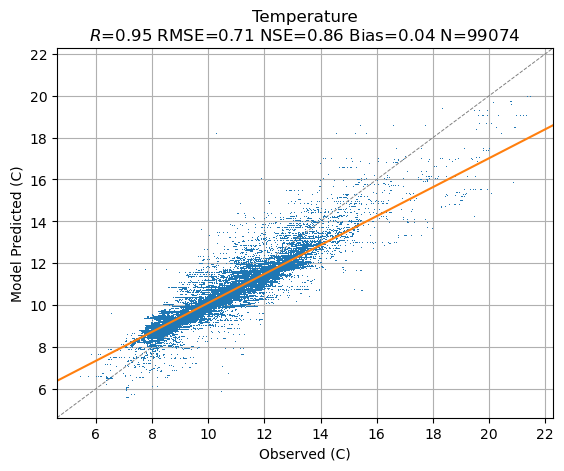

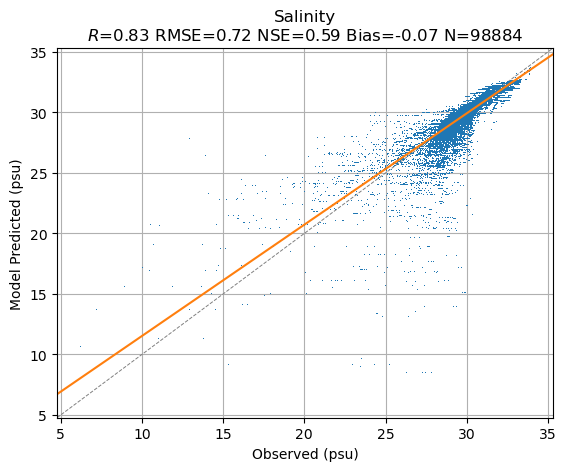

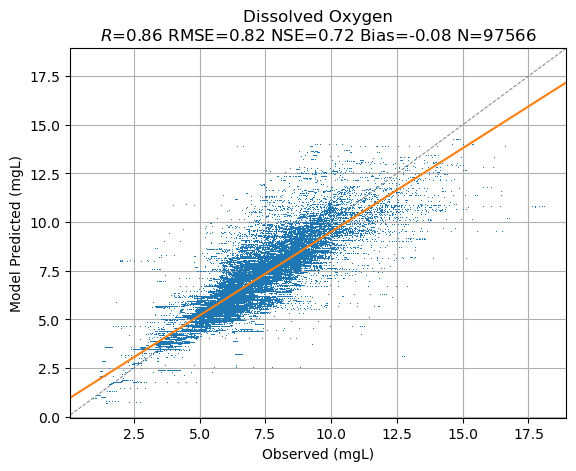

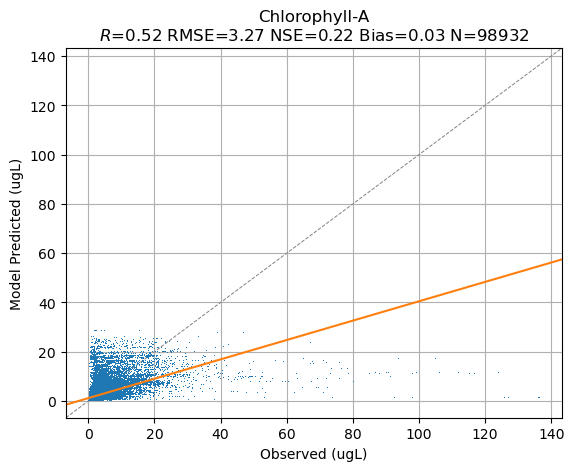

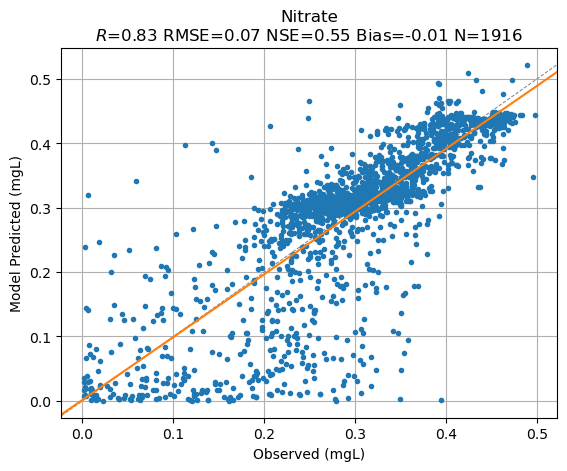

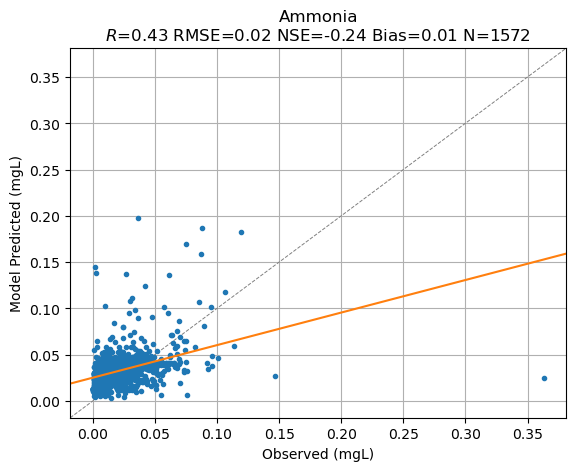

In [4]:
hydro_col_names = {
    'Temperature': {
        'col': 'Temp_C',
        'var': 'temp'
    },
    'Salinity': {
        'col': 'Salinity_psu',
        'var': 'salinity'
    }
}

wqm_col_names = {
    'Dissolved Oxygen': {
        'col': 'DO_mgL',
        'var': 'DOXG'
    },
    'Chlorophyll-A': {
        'col': 'Chla_ugL',
        'var': ('B1','B2'),
        'ratio': (1000/37, 1000/50)
    },
    'Nitrate': {
        'col': 'NO23N_mgL',
        'var': 'NO3'
    },
    'Ammonia': {
        'col': 'NH4N_mgL',
        'var': 'NH4'
    }
}

for cst,coldata in (hydro_col_names | wqm_col_names).items():
    fig, ax = plt.subplots()
    colname = coldata['col']
    unit = colname.split('_')[-1]
    data_sub = data.dropna(subset=(colname, 'Model_' + colname))
    vu.plot_fit(ax, data_sub[colname], data_sub['Model_' + colname], cst, unit=unit)


In [5]:
start_dt = pd.Timestamp(model_start_date)
hydro_t_midpoints = start_dt + pd.to_timedelta((hydro_ds['time'][:-1] + hydro_ds['time'][1:]) / 2, 's')
wqm_t_midpoints = start_dt + pd.to_timedelta((wqm_ds['time'][:-1] + wqm_ds['time'][1:]) / 2, 's')

data['Hydro_T'] = np.searchsorted(hydro_t_midpoints, data['Model_Time'])
data['WQM_T'] = np.searchsorted(wqm_t_midpoints, data['Model_Time'])

In [6]:
for cst,coldata in (hydro_col_names | wqm_col_names).items():
    data['Model_' + coldata['col']] = np.nan

for n,group in data.groupby('Nodes'):
    node_selector = (data['Nodes'] == n)
    for t,group2 in group.groupby('Hydro_T'):
        t_selector = (data['Hydro_T'] == t)
        for l,group3 in group2.groupby('Layer'):
            selector = node_selector & t_selector & (data['Layer'] == l)
            for cst,coldata in hydro_col_names.items():
                if np.ndim(coldata['var']) == 0:
                    value = hydro_ds[coldata['var']][t,l-1,n-1] * (coldata['ratio'] if 'ratio' in coldata else 1)
                else:
                    value = np.array([hydro_ds[v][t,l-1,n-1] * r for v,r in zip(coldata['var'],coldata['ratio'])]).sum()
                data.loc[selector, 'Model_' + coldata['col']] = value
    for t,group2 in group.groupby('WQM_T'):
        t_selector = (data['WQM_T'] == t)
        for l,group3 in group2.groupby('Layer'):
            selector = node_selector & t_selector & (data['Layer'] == l)
            for cst,coldata in wqm_col_names.items():
                if np.ndim(coldata['var']) == 0:
                    value = wqm_ds[coldata['var']][t,l-1,n-1] * (coldata['ratio'] if 'ratio' in coldata else 1)
                else:
                    value = np.array([wqm_ds[v][t,l-1,n-1] * r for v,r in zip(coldata['var'],coldata['ratio'])]).sum()
                data.loc[selector, 'Model_' + coldata['col']] = value

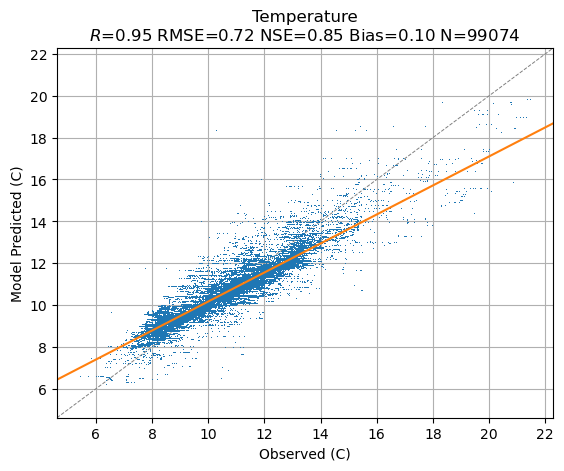

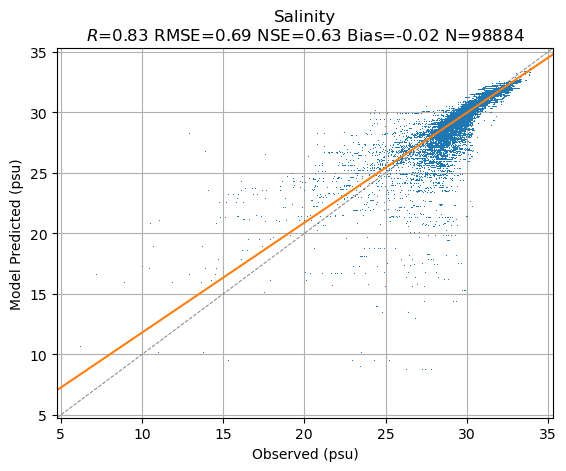

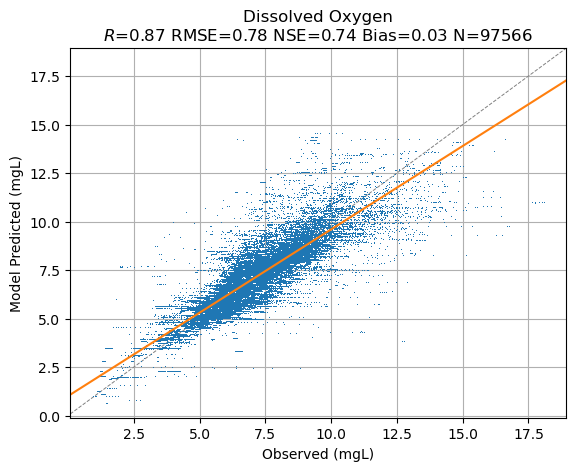

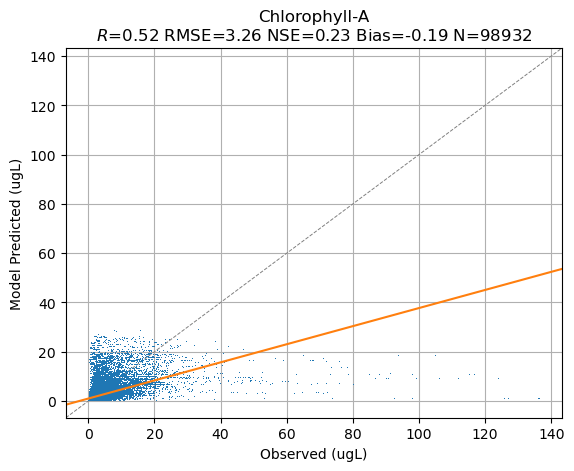

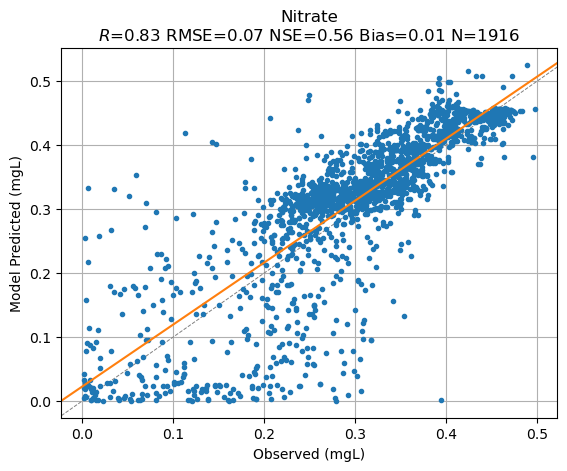

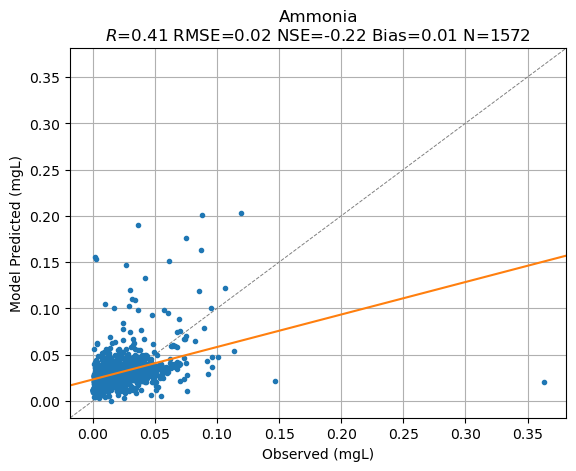

In [7]:
for cst,coldata in (hydro_col_names | wqm_col_names).items():
    fig, ax = plt.subplots()
    colname = coldata['col']
    unit = colname.split('_')[-1]
    data_sub = data.dropna(subset=(colname, 'Model_' + colname))
    vu.plot_fit(ax, data_sub[colname], data_sub['Model_' + colname], cst, unit=unit)